[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-fine-tune-paligemma/)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://www.youtube.com/watch?v=OMBmVInx68M)

PaliGemma is an open vision-language model (VLM) inspired by PaLI-3, built with
open components, such as
the [SigLIP vision model](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)
and
the [Gemma language model](https://ai.google.dev/gemma).
PaliGemma is designed as a versatile model for transfer to a wide range of
vision-language tasks such as image and short video caption, visual question
answering, text reading, object detection and object segmentation. Together with
the pretrained and transfer checkpoints at multiple resolutions, we provide a
checkpoint transferred to a mixture of tasks that can be used for off-the-shelf
exploration.

This notebook is an extension of the [official notebook](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb) prepared by Google Research.

![PaliGemma model](https://storage.cloud.google.com/com-roboflow-marketing/notebooks/examples/paligemma.png)

This notebook shows how to fine-tune [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [JAX](https://jax.readthedocs.io/en/latest/index.html). *Fine-tuning* is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

## Setup

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [`Kaggle`](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [`PaliGemma Model Card`](https://www.kaggle.com/models/google/paligemma/) and click `Request Access`.
1. Complete the consent form and accept the terms and conditions.

### Configure your API keys

To use PaliGemma, you need to provide your Kaggle username, Kaggle API key, and Roboflow API key. Follow these steps:

- Open your [`Kaggle Settings`](https://www.kaggle.com/settings) page. Click `Create New Token`. This will download a `kaggle.json` file containing your API credentials.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store Kaggle Username under the name `KAGGLE_USERNAME`.
    - Store Kaggle API Key under the name `KAGGLE_KEY`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Feb 23 06:53:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Download dataset from Roboflow Universe

To fine-tune PaliGemma, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [2]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9SJZLUuYyJw1t72TSYaA")
project = rf.workspace("nuel").project("ct-brain-hemorrhage-0ac7k")
version = project.version(2)
dataset = version.download("paligemma")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ct-brain-hemorrhage-2 in paligemma:: 100%|██████████| 3574/3574 [00:00<00:00, 6844.34it/s]


In [4]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"ID_7e6d99b26_png_jpg.rf.0001bc57d3ab4f9383d5120c039c2950.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0294><loc0714><loc0696><loc0896> Subdural ; <loc0582><loc0462><loc0696><loc0576> Intraparenchymal"}
{"image":"ID_6cf77dbd0_png_jpg.rf.005bae4e8c48f1adb6dd1f06548625ea.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0150><loc0454><loc0302><loc0570> Subdural"}
{"image":"ID_f7f6e0778_png_jpg.rf.010a5417e123d3cb9ac3136c6a9bb572.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0217><loc0426><loc0715><loc0578> Subdural"}
{"image":"ID_6bee5a25e_png_jpg.rf.0074111bef1458039d785b190fd43f7a.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0194><loc0234><loc0446><loc0442> Subdural"}
{"image":"ID_20f1f3709_png_jpg.rf.008c1be28c8046b080857e9cdd19ae7b.jpg","prefix":"detect Intraparenchyma

In [5]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"ID_7a3fa1e44_png_jpg.rf.00104423bc83e2f0e5d2d51c17e1679d.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0676><loc0416><loc0912><loc0594> Subdural"}
{"image":"ID_5f7d65369_png_jpg.rf.028bf2b7310d62aa4c5a662cc7538d3e.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0381><loc0542><loc0907><loc0810> Subdural"}
{"image":"ID_39afa9d2e_png_jpg.rf.01601a85f11539039ce224fc7da6057f.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0264><loc0115><loc0660><loc0377> Subdural"}
{"image":"ID_640955884_png_jpg.rf.004ef0cd9d76383ac3eea6a2cc8ff6bb.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix":"<loc0532><loc0332><loc0852><loc0478> Subdural"}
{"image":"ID_3152835d7_png_jpg.rf.05b32082dbfe9c23420eaed116f3cb80.jpg","prefix":"detect Intraparenchymal ; Intraventricular ; Subarachnoid ; Subdural","suffix"

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s

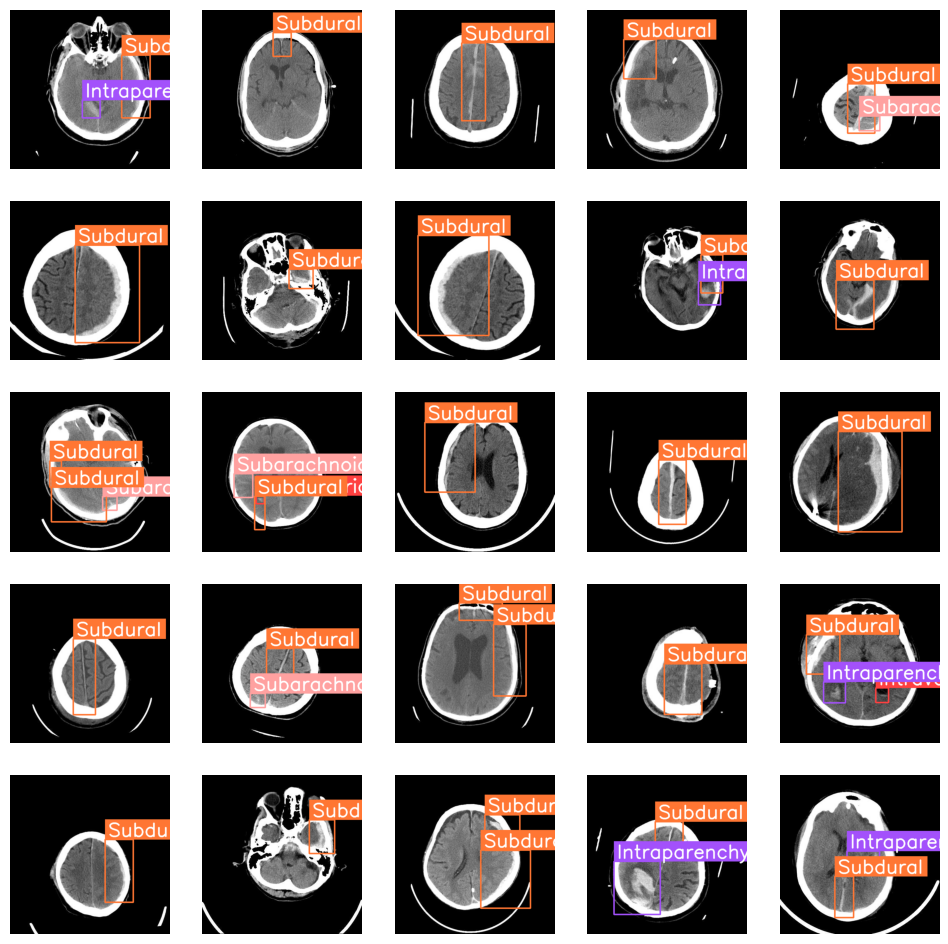

In [7]:
import cv2
import json
import supervision as sv
from typing import List

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [8]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.2 MB/s eta 0:00:00


### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [10]:
import shutil
import os

# Create the folder if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", "/root/.kaggle/")
os.chmod("/root/.kaggle/kaggle.json", 600)


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [11]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [12]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [05:53<00:00, 16.5MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [13]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [14]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [15]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once. This allows you to do some data pre-processing before use.
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results.

In [16]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s

<loc0659><loc0374><loc0939><loc0534> subdural ; <loc0473><loc0426><loc0657><loc0656> intraparenchymal
<loc0444><loc0422><loc0810><loc0642> subdural
<loc0300><loc0218><loc0870><loc0514> subdural
<loc0202><loc0368><loc0340><loc0518> subdural
Training examples



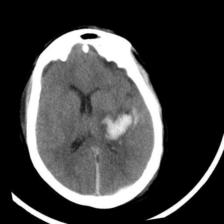
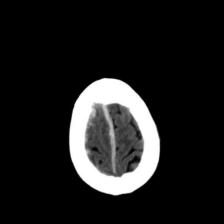
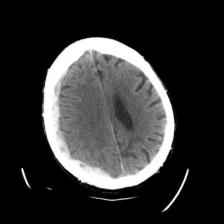
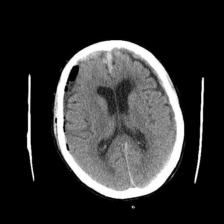

In [17]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [18]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

<loc0127><loc0236><loc0896><loc0827> subdural ; <loc0000><loc0000><loc1023><loc1015> intraventricular ; <loc0127><loc0246><loc0887><loc0824> subarachnoid ; <loc0000><loc0000><loc1023><loc1015> intraparenchymal
<loc0160><loc0174><loc0964><loc0822> intraventricular ; <loc0167><loc0189><loc0896><loc0812> subdural ; <loc0279><loc0241><loc0854><loc0767> subarachnoid ; <loc0474><loc0495><loc0503><loc0537> intraparenchymal
<loc0277><loc0192><loc0927><loc0670> subarachnoid ; <loc0209><loc0121><loc0997><loc0726> intraventricular ; <loc0277><loc0202><loc0921><loc0670> intraparenchymal ; <loc0000><loc0000><loc1023><loc1015> subdural
<loc0311><loc0321><loc0824><loc0797> subarachnoid ; <loc0241><loc0270><loc0869><loc0854> intraventricular ; <loc0000><loc0000><loc1018><loc1013> subdural ; <loc0312><loc0335><loc0813><loc0785> intraparenchymal


SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


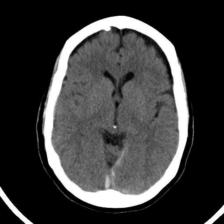
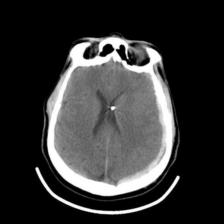
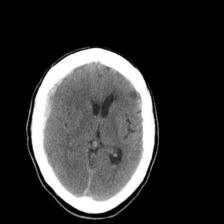
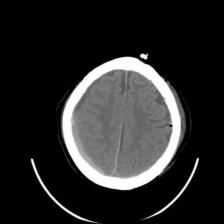

In [19]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

step:  1/250   lr: 0.00020   loss: 2.9331
step:  2/250   lr: 0.00040   loss: 2.9552
step:  3/250   lr: 0.00060   loss: 2.7767
step:  4/250   lr: 0.00080   loss: 2.9116
step:  5/250   lr: 0.00100   loss: 2.9028
step:  6/250   lr: 0.00120   loss: 2.8344
step:  7/250   lr: 0.00140   loss: 3.1416
step:  8/250   lr: 0.00160   loss: 2.9902
step:  9/250   lr: 0.00180   loss: 3.2634
step: 10/250   lr: 0.00200   loss: 2.9762
step: 11/250   lr: 0.00220   loss: 2.9966
step: 12/250   lr: 0.00240   loss: 2.9115
step: 13/250   lr: 0.00260   loss: 2.9695
step: 14/250   lr: 0.00280   loss: 2.9096
step: 15/250   lr: 0.00300   loss: 3.1154
step: 16/250   lr: 0.00320   loss: 3.0035
step: 17/250   lr: 0.00340   loss: 2.9947
step: 18/250   lr: 0.00360   loss: 3.0251
step: 19/250   lr: 0.00380   loss: 2.9906
step: 20/250   lr: 0.00400   loss: 2.9660
step: 21/250   lr: 0.00420   loss: 3.2024
step: 22/250   lr: 0.00440   loss: 3.1626
step: 23/250   lr: 0.00460   loss: 3.2298
step: 24/250   lr: 0.00480   loss:

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


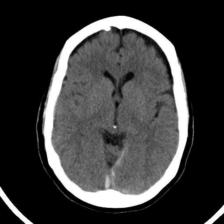
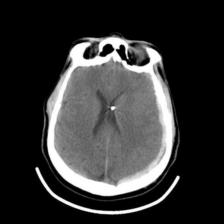
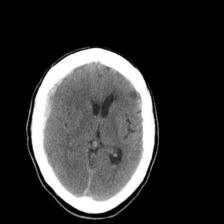
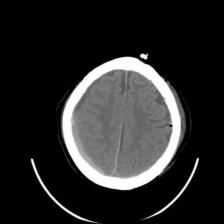

step: 32/250   lr: 0.00499   loss: 3.0711
step: 33/250   lr: 0.00498   loss: 3.0075
step: 34/250   lr: 0.00498   loss: 3.0068
step: 35/250   lr: 0.00498   loss: 3.0237
step: 36/250   lr: 0.00497   loss: 2.7981
step: 37/250   lr: 0.00497   loss: 3.1870
step: 38/250   lr: 0.00496   loss: 2.9591
step: 39/250   lr: 0.00495   loss: 3.0309
step: 40/250   lr: 0.00495   loss: 3.1641
step: 41/250   lr: 0.00494   loss: 3.1871
step: 42/250   lr: 0.00493   loss: 3.0417
step: 43/250   lr: 0.00492   loss: 3.0733
step: 44/250   lr: 0.00491   loss: 3.1734
step: 45/250   lr: 0.00490   loss: 3.1636
step: 46/250   lr: 0.00489   loss: 2.9849
step: 47/250   lr: 0.00488   loss: 3.0365
step: 48/250   lr: 0.00487   loss: 2.9848
step: 49/250   lr: 0.00486   loss: 3.0761
step: 50/250   lr: 0.00485   loss: 3.0851
step: 51/250   lr: 0.00484   loss: 3.1519
step: 52/250   lr: 0.00483   loss: 3.0095
step: 53/250   lr: 0.00481   loss: 3.0607
step: 54/250   lr: 0.00480   loss: 3.0305
step: 55/250   lr: 0.00479   loss:

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


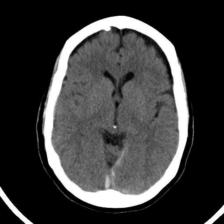
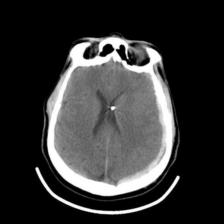
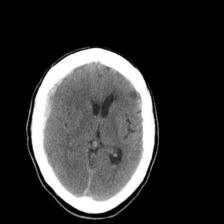
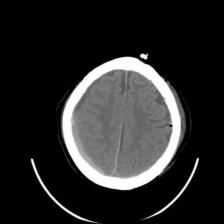

step: 63/250   lr: 0.00466   loss: 2.8438
step: 64/250   lr: 0.00464   loss: 3.2153
step: 65/250   lr: 0.00462   loss: 2.9539
step: 66/250   lr: 0.00460   loss: 3.0161
step: 67/250   lr: 0.00459   loss: 3.0857
step: 68/250   lr: 0.00457   loss: 2.9654
step: 69/250   lr: 0.00455   loss: 2.9860
step: 70/250   lr: 0.00453   loss: 3.0854
step: 71/250   lr: 0.00451   loss: 2.9497
step: 72/250   lr: 0.00449   loss: 2.9424
step: 73/250   lr: 0.00446   loss: 3.0079
step: 74/250   lr: 0.00444   loss: 3.0549
step: 75/250   lr: 0.00442   loss: 3.0134
step: 76/250   lr: 0.00440   loss: 3.0250
step: 77/250   lr: 0.00437   loss: 2.9887
step: 78/250   lr: 0.00435   loss: 2.8588
step: 79/250   lr: 0.00433   loss: 2.9854
step: 80/250   lr: 0.00430   loss: 2.9132
step: 81/250   lr: 0.00428   loss: 2.9555
step: 82/250   lr: 0.00426   loss: 2.9676
step: 83/250   lr: 0.00423   loss: 2.8927
step: 84/250   lr: 0.00421   loss: 3.0731
step: 85/250   lr: 0.00418   loss: 2.9603
step: 86/250   lr: 0.00415   loss:

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


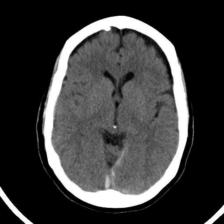
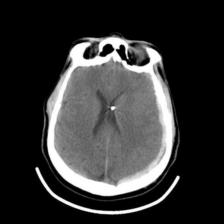
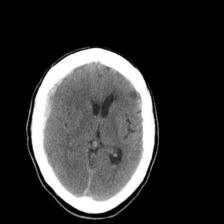
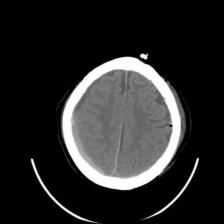

step: 94/250   lr: 0.00394   loss: 2.9588
step: 95/250   lr: 0.00391   loss: 2.8721
step: 96/250   lr: 0.00388   loss: 2.8981
step: 97/250   lr: 0.00385   loss: 2.9640
step: 98/250   lr: 0.00382   loss: 2.8039
step: 99/250   lr: 0.00379   loss: 2.8163
step: 100/250   lr: 0.00376   loss: 3.1847
step: 101/250   lr: 0.00373   loss: 3.0019
step: 102/250   lr: 0.00370   loss: 3.0599
step: 103/250   lr: 0.00367   loss: 3.0536
step: 104/250   lr: 0.00364   loss: 2.8175
step: 105/250   lr: 0.00361   loss: 3.0835
step: 106/250   lr: 0.00358   loss: 2.8089
step: 107/250   lr: 0.00354   loss: 2.7689
step: 108/250   lr: 0.00351   loss: 3.1990
step: 109/250   lr: 0.00348   loss: 2.8690
step: 110/250   lr: 0.00345   loss: 2.8663
step: 111/250   lr: 0.00342   loss: 2.7976
step: 112/250   lr: 0.00338   loss: 2.9287
step: 113/250   lr: 0.00335   loss: 3.2350
step: 114/250   lr: 0.00332   loss: 2.6844
step: 115/250   lr: 0.00329   loss: 2.9834
step: 116/250   lr: 0.00325   loss: 3.0968
step: 117/250   l

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


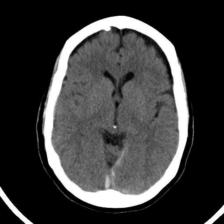
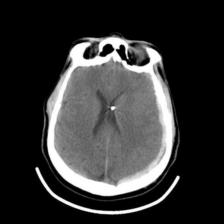
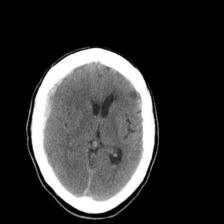
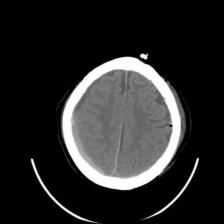

step: 125/250   lr: 0.00295   loss: 3.0960
step: 126/250   lr: 0.00292   loss: 2.8952
step: 127/250   lr: 0.00288   loss: 3.0391
step: 128/250   lr: 0.00285   loss: 3.0281
step: 129/250   lr: 0.00281   loss: 3.0206
step: 130/250   lr: 0.00278   loss: 3.0006
step: 131/250   lr: 0.00274   loss: 2.9276
step: 132/250   lr: 0.00271   loss: 2.9939
step: 133/250   lr: 0.00267   loss: 2.9581
step: 134/250   lr: 0.00264   loss: 2.8883
step: 135/250   lr: 0.00260   loss: 3.0281
step: 136/250   lr: 0.00257   loss: 2.9305
step: 137/250   lr: 0.00253   loss: 2.9148
step: 138/250   lr: 0.00250   loss: 2.9716
step: 139/250   lr: 0.00247   loss: 2.9534
step: 140/250   lr: 0.00243   loss: 3.0560
step: 141/250   lr: 0.00240   loss: 2.8827
step: 142/250   lr: 0.00236   loss: 3.1707
step: 143/250   lr: 0.00233   loss: 3.0520
step: 144/250   lr: 0.00229   loss: 2.9215
step: 145/250   lr: 0.00226   loss: 2.8992
step: 146/250   lr: 0.00222   loss: 2.8003
step: 147/250   lr: 0.00219   loss: 2.8417
step: 148/2

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


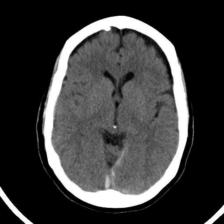
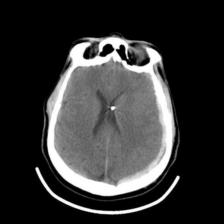
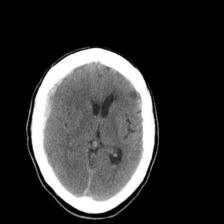
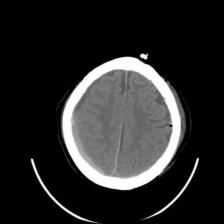

step: 156/250   lr: 0.00188   loss: 2.8811
step: 157/250   lr: 0.00185   loss: 2.9949
step: 158/250   lr: 0.00181   loss: 2.9700
step: 159/250   lr: 0.00178   loss: 2.9637
step: 160/250   lr: 0.00175   loss: 3.0173
step: 161/250   lr: 0.00171   loss: 3.0292
step: 162/250   lr: 0.00168   loss: 2.9177
step: 163/250   lr: 0.00165   loss: 2.9214
step: 164/250   lr: 0.00162   loss: 2.9452
step: 165/250   lr: 0.00158   loss: 3.0046
step: 166/250   lr: 0.00155   loss: 2.9948
step: 167/250   lr: 0.00152   loss: 2.9285
step: 168/250   lr: 0.00149   loss: 2.7423
step: 169/250   lr: 0.00146   loss: 2.9574
step: 170/250   lr: 0.00142   loss: 2.8979
step: 171/250   lr: 0.00139   loss: 2.8623
step: 172/250   lr: 0.00136   loss: 3.0705
step: 173/250   lr: 0.00133   loss: 3.0761
step: 174/250   lr: 0.00130   loss: 2.9054
step: 175/250   lr: 0.00127   loss: 3.0897
step: 176/250   lr: 0.00124   loss: 2.9667
step: 177/250   lr: 0.00121   loss: 2.8553
step: 178/250   lr: 0.00118   loss: 3.0284
step: 179/2

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


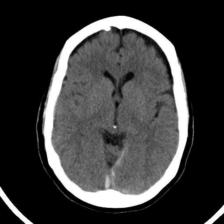
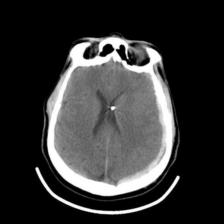
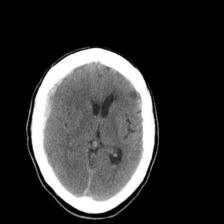
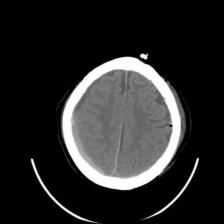

step: 187/250   lr: 0.00093   loss: 3.1525
step: 188/250   lr: 0.00090   loss: 3.1009
step: 189/250   lr: 0.00087   loss: 2.8719
step: 190/250   lr: 0.00085   loss: 2.7009
step: 191/250   lr: 0.00082   loss: 2.9504
step: 192/250   lr: 0.00079   loss: 2.9929
step: 193/250   lr: 0.00077   loss: 2.7319
step: 194/250   lr: 0.00074   loss: 2.7431
step: 195/250   lr: 0.00072   loss: 2.8598
step: 196/250   lr: 0.00070   loss: 2.8732
step: 197/250   lr: 0.00067   loss: 2.8242
step: 198/250   lr: 0.00065   loss: 2.8884
step: 199/250   lr: 0.00063   loss: 2.6664
step: 200/250   lr: 0.00060   loss: 3.0813
step: 201/250   lr: 0.00058   loss: 2.8996
step: 202/250   lr: 0.00056   loss: 2.8712
step: 203/250   lr: 0.00054   loss: 3.0613
step: 204/250   lr: 0.00051   loss: 2.7553


KeyboardInterrupt: 

In [28]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 2000
LEARNING_RATE = 0.005

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


## Evaluate fine-tuned model

<loc0674><loc0432><loc0903><loc0603> subdural
<loc0620><loc0408><loc0887><loc0559> subdural
<loc0303><loc0123><loc0789><loc0335> subdural
<loc0536><loc0465><loc0844><loc0609> subdural
<loc0505><loc0399><loc0870><loc0541> subdural
<loc0463><loc0216><loc0686><loc0366> subdural
<loc0303><loc0502><loc0754><loc0766> subdural
<loc0263><loc0408><loc0432><loc0531> subdural
<loc0303><loc0470><loc0661><loc0609> subdural
<loc0653><loc0270><loc0893><loc0453> subdural
<loc0559><loc0408><loc0869><loc0601> subdural
<loc0128><loc0141><loc0531><loc0470> subdural
<loc0279><loc0754><loc0789><loc0975> subdural
<loc0373><loc0485><loc0896><loc0826> subdural
<loc0321><loc0270><loc0921><loc0531> subdural
<loc0295><loc0206><loc0617><loc0397> subdural


SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s


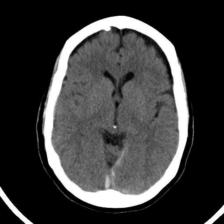
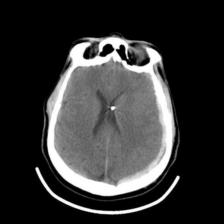
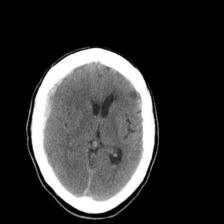
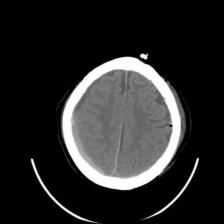
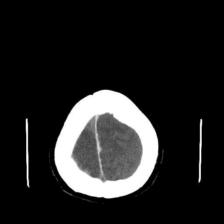
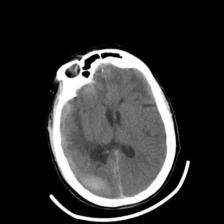
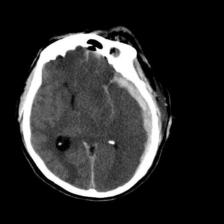
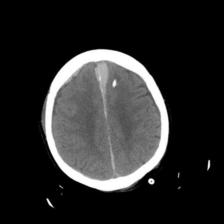
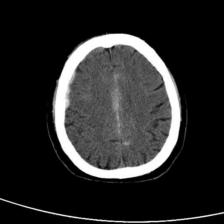
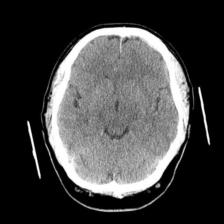
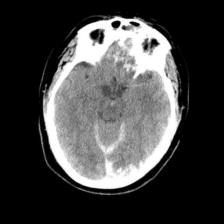
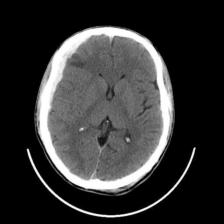
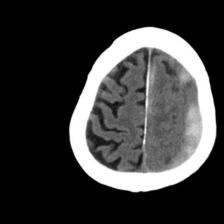
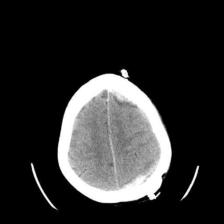
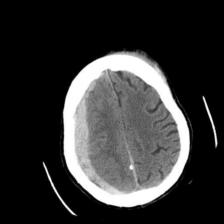
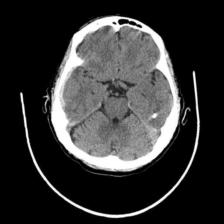

In [29]:
# @title Visualize results
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=16, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

In [32]:
# @title Collect predictions
targets = []
predictions = []
images=[]
for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=30, batch_size=8):
    h, w, _ = image.shape
    images.append(image)
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s

SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
SupervisionWarnings: LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
SupervisionWarnings: from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `s

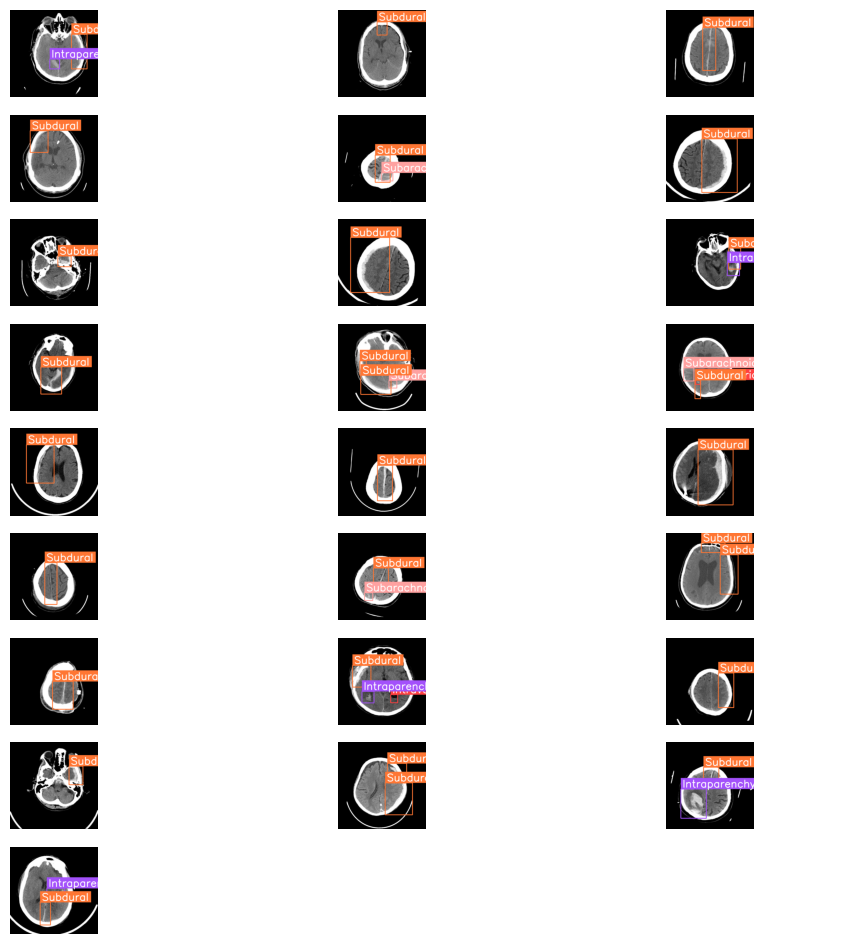

In [36]:

def read_n_lines(file_path: str, n: int) -> List[str]:
    """Reads the first n lines from a file."""
    lines = []
    with open(file_path, 'r') as file:
        for _ in range(n):
            try:
                lines.append(next(file).strip())
            except StopIteration:
                break  # Stop if file has fewer than n lines
    return lines

# Load annotation lines
annotation_file = f"{dataset.location}/dataset/_annotations.train.jsonl"
lines = read_n_lines(annotation_file, 25)

if not lines:
    raise ValueError("No annotation data found.")

# Extract class labels
first_entry = json.loads(lines[0])
CLASSES = first_entry.get('prefix', "").replace("detect ", "").split(" ; ")

# Load your trained model
model = torch.load("your_model.pth")  # Replace with actual model path
model.eval()

# Define box annotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_scale=2, text_thickness=4)

images = []

for line in lines:
    try:
        data = json.loads(line)
        image_path = f"{dataset.location}/dataset/{data.get('image')}"
        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Failed to load image {image_path}")
            continue

        h, w, _ = image.shape

        # Convert image to tensor and run prediction
        image_tensor = torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0) / 255.0
        with torch.no_grad():
            predictions = model(image_tensor)  # Assuming model returns bounding boxes

        # Convert predictions into Supervision's format
        detections = []
        for pred in predictions[0]:  # Assuming batch size of 1
            x_min, y_min, x_max, y_max, class_id, confidence = pred.tolist()

            # Filter low confidence predictions
            if confidence < 0.5:
                continue

            detections.append(sv.Detection(
                xyxy=[x_min, y_min, x_max, y_max],
                confidence=confidence,
                class_id=int(class_id)
            ))

        # Annotate image
        image = box_annotator.annotate(image, detections)
        image = label_annotator.annotate(image, detections, labels=[CLASSES[d.class_id] for d in detections])

        images.append(image)

    except json.JSONDecodeError:
        print("Warning: Skipping invalid JSON entry.")
    except Exception as e:
        print(f"Error processing image: {e}")

# Display images in a 3-column layout
num_images = len(images)
num_rows = math.ceil(num_images / 3)  # Compute rows dynamically

if images:
    sv.plot_images_grid(images, (num_rows, 3))
else:
    print("No valid images to display.")


In [35]:
prediction

Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U8')}, metadata={})

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.83
map50: 0.94
map75: 0.90


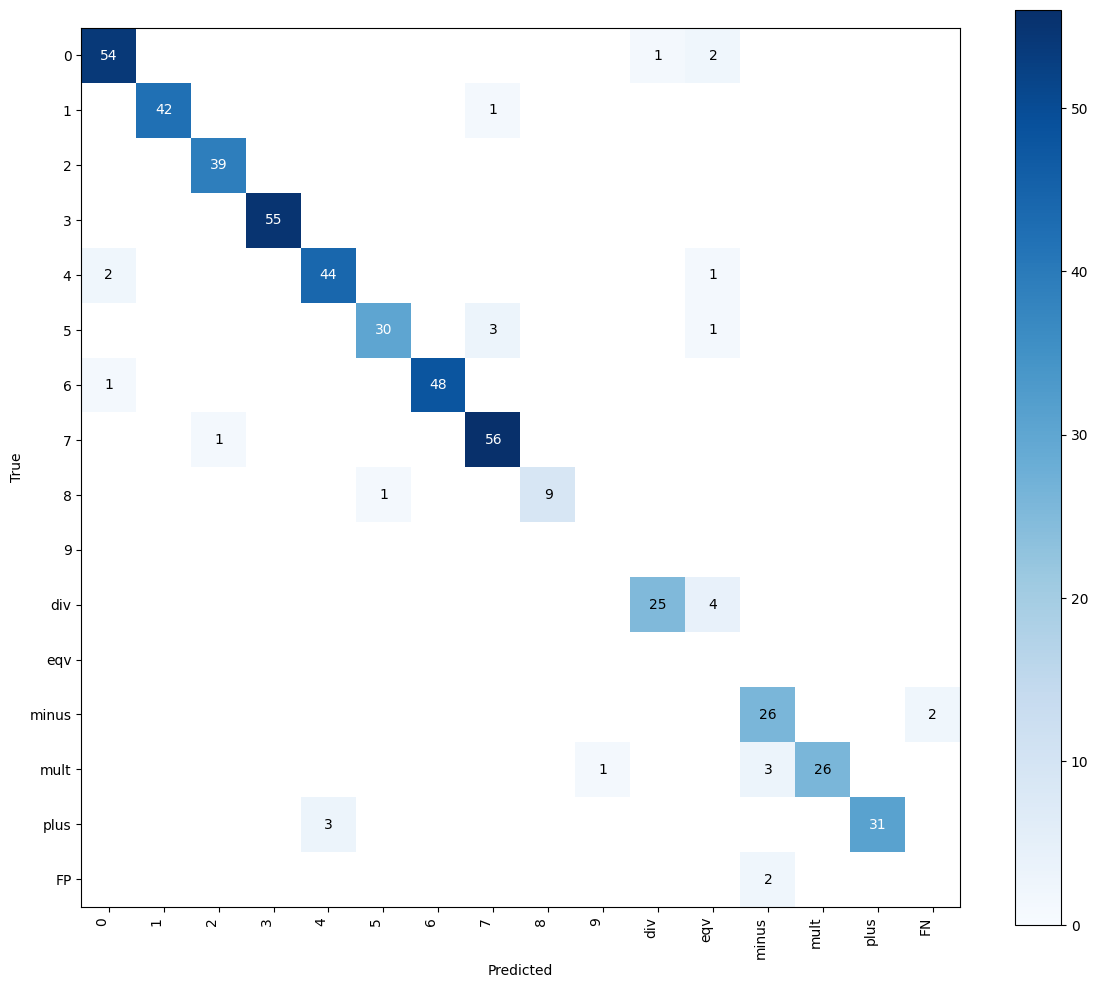

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model locally

In [ ]:
import os

TARGET_MODEL_DIR = f"{dataset.location}/model"
TARGET_MODEL_PATH = f"{TARGET_MODEL_DIR}/paligemma-3b-pt-224.f16.npz"

os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

In [ ]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

## Deploy model on Roboflow

In [ ]:
version.deploy(model_type="paligemma-3b-pt-224", model_path=TARGET_MODEL_DIR)

Model files found in /content/number-ops-1/model: ['paligemma-3b-pt-224.f16.npz']
Found .npz file paligemma-3b-pt-224.f16.npz in model path. Deploying JAX PaliGemma model.
Zipping files for deploy: ['paligemma-3b-pt-224.f16.npz']
Uploading to Roboflow... May take several minutes.
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/number-ops-j1426/1
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/number-ops-j1426/model/1


# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️